In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


This block is uploading the Dataset.

In [ ]:
from google.colab import files

df = pd.read_csv('stock_1.csv')

This block processes raw order book data to create useful features for modeling. It calculates mid-price, spread, order book imbalance, and momentum to describe market behavior. Then it computes realized volatility (standard deviation of mid-price) for each time_id, and merges that back into the dataset. Finally, the data is sorted by time for consistency.




In [ ]:
# Compute mid price as the average of best bid and ask prices
df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2

# Compute bid-ask spread
df['spread'] = df['ask_price1'] - df['bid_price1']

# Calculate order book imbalance: (bid_size1 - ask_size1) / (bid_size1 + ask_size1)
df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'] + 1e-9)

# Calculate price momentum: change in mid_price from the previous second in the same time_id
df['momentum'] = df.groupby('time_id')['mid_price'].diff().fillna(0)

# Compute realized volatility for each time_id
volatility_per_id = df.groupby('time_id')['mid_price'].std().reset_index()
volatility_per_id.columns = ['time_id', 'volatility']

# Merge the volatility values back to each record
df = df.merge(volatility_per_id, on='time_id', how='left')

# Sort data by time_id and time within each id
df = df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)


This block prepares the input and target data for the LSTM model.
It loops through each time interval (time_id) and extracts the first 100 seconds of engineered features (mid_price, spread, etc.). These form the input sequences. For each sequence, the target is the volatility of the next time interval.
If any sequence is shorter than 100 steps, it is padded with the last known values.
The result is a clean dataset where each input is a (100, 6) matrix, and each output is a single volatility value.



In [ ]:

# Define which feature columns to use for LSTM input
feature_cols = ['mid_price', 'spread', 'imbalance', 'momentum', 'bid_size1', 'ask_size1']

# Get sorted unique time_ids
time_ids = sorted(df['time_id'].unique())

X_sequences = []
y_targets = []

for i in range(len(time_ids) - 1):
    current_id = time_ids[i]
    next_id = time_ids[i+1]

    # Extract the data for the current time_id
    interval_data = df[df['time_id'] == current_id]
    interval_data = interval_data.sort_values('seconds_in_bucket')

    # If there are more than 100 seconds, we take the first 100 (as specified)
    sequence_data = interval_data.head(100)

    # Extract the feature values for this sequence
    X_seq = sequence_data[feature_cols].values

    # If the interval had fewer than 100 rows for some reason, we can pad it (not needed if all >=100)
    if X_seq.shape[0] < 100:

        pad_length = 100 - X_seq.shape[0]
        X_seq = np.pad(X_seq, ((0, pad_length), (0, 0)), mode='edge')

    X_seq = X_seq[:100]
    target_vol = volatility_per_id[volatility_per_id['time_id'] == next_id]['volatility'].values[0]

    X_sequences.append(X_seq)
    y_targets.append(target_vol)

# Convert lists to numpy arrays for modeling
X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

print("Total sequences prepared:", X_sequences.shape[0])
print("Sequence shape (time steps, features):", X_sequences.shape[1], X_sequences.shape[2])
print("First target volatility examples:", y_targets[:5])


Total sequences prepared: 3829
Sequence shape (time steps, features): 100 6
First target volatility examples: [0.0003186  0.00084469 0.00061807 0.0003518  0.00300356]


This code splits the dataset into training (80%) and testing (20%) sets while keeping the time order intact. It then applies MinMaxScaler to normalize all feature values between 0 and 1, which helps the LSTM model train more effectively. The input sequences are reshaped before and after scaling to fit the expected format for the model: (samples, time steps, features). Finally, the target values (y_train and y_test) are reshaped into column vectors to match the model's output format.



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_targets, test_size=0.2, shuffle=False
)


print("Training samples:", X_train.shape[0], "Testing samples:", X_test.shape[0])

scaler = MinMaxScaler(feature_range=(0, 1))

num_train_samples = X_train.shape[0]
X_train_2d = X_train.reshape(num_train_samples * 100, -1)

scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape[0], 100, -1)
X_test_scaled  = scaler.transform(X_test.reshape(X_test.shape[0] * 100, -1)).reshape(X_test.shape[0], 100, -1)

X_train = X_train_scaled
X_test = X_test_scaled

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("Scaled X_train shape:", X_train.shape, "Scaled X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)


Training samples: 3063 Testing samples: 766
Scaled X_train shape: (3063, 100, 6) Scaled X_test shape: (766, 100, 6)
y_train shape: (3063, 1) y_test shape: (766, 1)


This code builds a sequential LSTM model designed to predict stock volatility based on time-series data. The model has two stacked LSTM layers. The first layer has 64 units and returns the full sequence to the next layer. The second LSTM layer has 32 units and outputs a summary of the sequence. Dropout layers are added after each LSTM to prevent overfitting by randomly turning off 20% of the neurons during training. The final output layer is a single neuron that predicts the volatility value. The model is compiled with Mean Squared Error (MSE) as the loss function and Adam as the optimizer. model.summary() prints a summary of the model's structure.



In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(100, len(feature_cols))))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 64)             │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

This code trains the LSTM model using the training data and monitors its performance on a validation set. It uses an EarlyStopping callback, which stops training if the validation loss doesn't improve for 5 consecutive epochs, and restores the best-performing weights. The model is trained for up to 50 epochs with a batch size of 32, and 20% of the training data is used for validation. After training, the model is evaluated on the test set to check how well it generalizes to unseen data. The final performance is measured using Mean Squared Error (MSE).

In [ ]:

# Define EarlyStopping callback to monitor validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on the training data, with a validation split for monitoring
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# After training, evaluate the model on the test set
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_mse:.6f}")


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.0025 - val_loss: 4.9654e-05
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 2.7238e-04 - val_loss: 1.2898e-05
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 1.5386e-04 - val_loss: 1.4985e-06
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 1.0635e-04 - val_loss: 1.8712e-05
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 7.3661e-05 - val_loss: 1.5386e-06
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 5.6898e-05 - val_loss: 1.6304e-06
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 4.5752e-05 - val_loss: 1.4422e-06
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 3.7517e-05 - val_loss: 1.3547e-06
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 3.1086e-05 - val_loss: 1.7853e-06
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 3.1690e-05 - val_loss: 1.3848e-06
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 2.47

This code visualizes how well the trained LSTM model performs by comparing its predicted volatility values to the actual volatility from the test set.

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


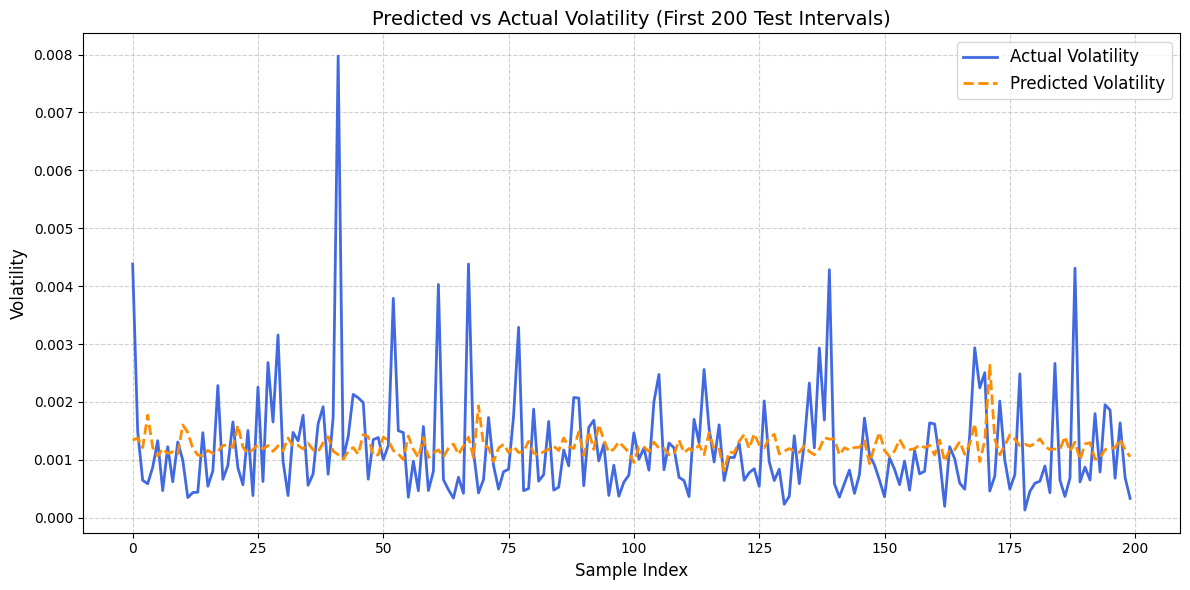

In [ ]:
y_pred = model.predict(X_test)

y_pred = y_pred.flatten()
y_true = y_test.flatten()

plot_count = 200
y_pred_plot = y_pred[:plot_count]
y_true_plot = y_true[:plot_count]

plt.figure(figsize=(12, 6))
plt.plot(y_true_plot, label='Actual Volatility', color='royalblue', linewidth=2)
plt.plot(y_pred_plot, label='Predicted Volatility', color='darkorange', linestyle='--', linewidth=2)
plt.title('Predicted vs Actual Volatility (First 200 Test Intervals)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
